Data Preprocessing and EDA



In [1]:
! pip install --index-url https://test.pypi.org/simple/ PyARMViz


Looking in indexes: https://test.pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 7.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from PyARMViz import PyARMViz

warnings.filterwarnings('ignore')

plt.style.use('seaborn')

data = pd.read_csv( "/content/bread basket.csv")

In [4]:
data.head()


,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


We would only need Transaction, Item and date time. Let's try and explore which are the top 30 selling products in the bakery using a network diagram.

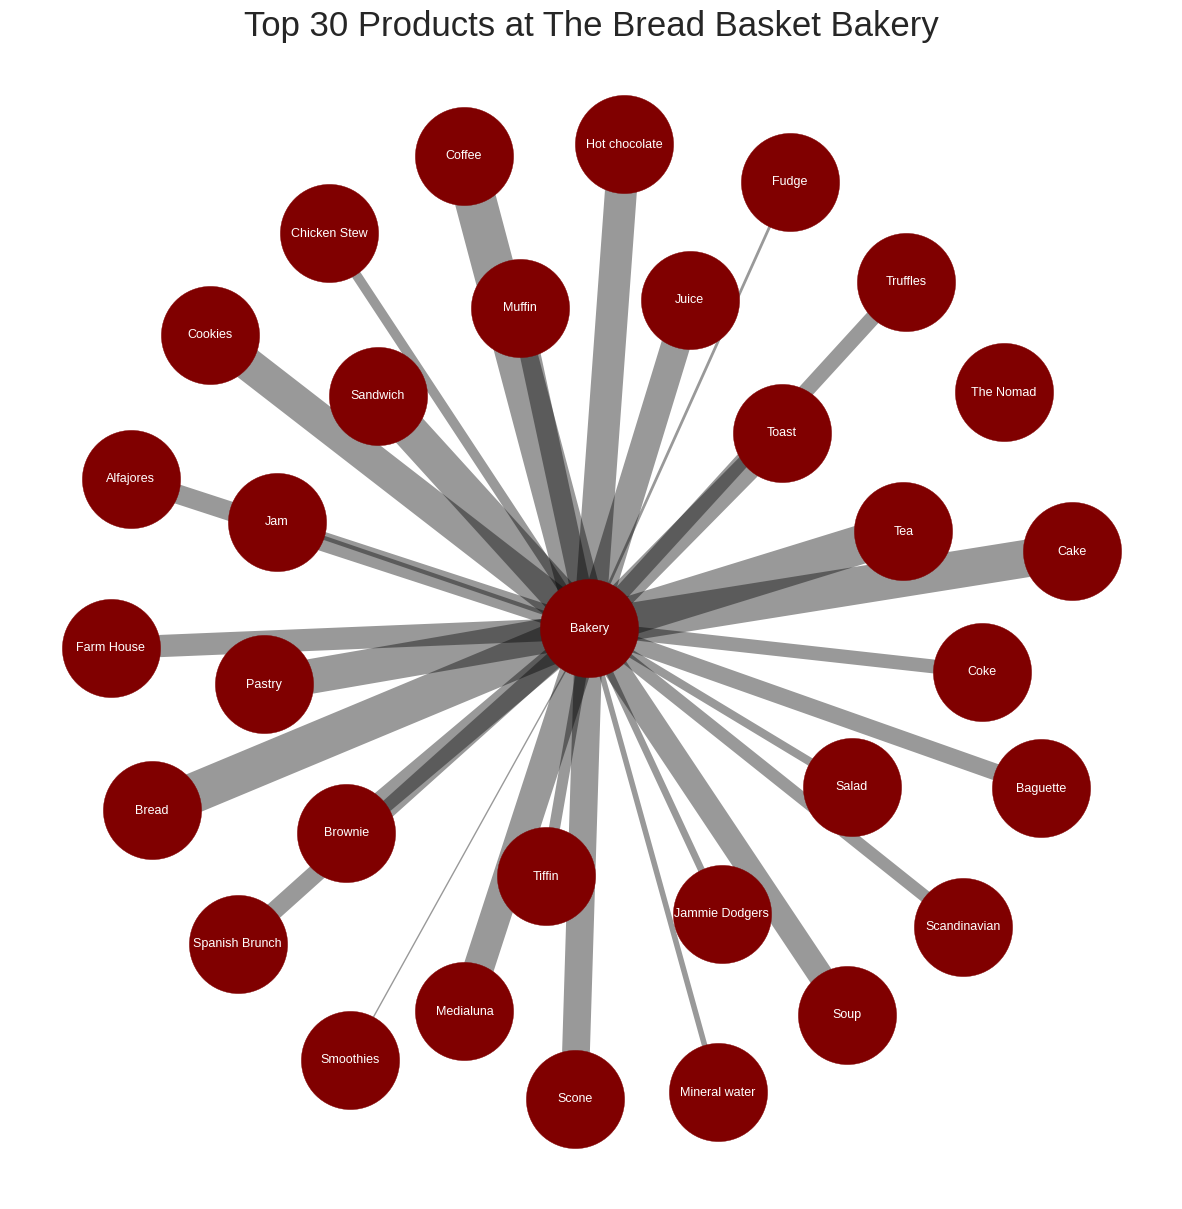

In [6]:
data_vis = data.copy()
df_network_first = data_vis.groupby("Item").sum().sort_values("Transaction", ascending=False).reset_index()
df_network_first["Type"] = "Bakery"
df_network_first = df_network_first.truncate(before=-1, after=30) # top 30
plt.rcParams['figure.figsize']=(15,15)
j = 0
for i, _ in reversed(list(enumerate(df_network_first['Transaction']))):
    df_network_first['Transaction'][j] = i
    j+=1
first_choice = nx.from_pandas_edgelist(df_network_first, source='Type', target="Item", edge_attr='Transaction')
prior = [i['Transaction'] for i in dict(first_choice.edges).values()]
pos = nx.spring_layout(first_choice)
nx.draw_networkx_nodes(first_choice, pos, node_size=5000, node_color="maroon")
nx.draw_networkx_edges(first_choice, pos, width=prior, alpha=0.4, edge_color='black')
nx.draw_networkx_labels(first_choice, pos, font_size=9, font_family='sans-serif', font_color = 'white')
plt.axis('off')
plt.grid()
plt.title('Top 30 Products at The Bread Basket Bakery', fontsize=25)
plt.show()

# **Data Modelling**

Its time to model the Apriori algorithm. We should first generate the frequent item set and then generate the association rules using the frequent item set. We need to ensure we generate a matrix with 0/1 values representating transaction presence of that item.

In [7]:
from mlxtend.frequent_patterns import association_rules, apriori

def encoder(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

apriori_data = data.groupby(['Transaction','Item'])['Item'].count().reset_index(name ='Count')
apriori_basket = apriori_data.pivot_table(index = 'Transaction', columns = 'Item', values = 'Count', aggfunc = 'sum').fillna(0)
apriori_basket_set = apriori_basket.applymap(encoder)
apriori_basket_set.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's first analyze the rules with min_support 5% and then for 1% respectively. Both using the metric lift.

In [8]:
f_items = apriori(apriori_basket_set, min_support = 0.05, use_colnames = True)
f_items

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.327205,(Bread)
1,0.103856,(Cake)
2,0.478394,(Coffee)
3,0.054411,(Cookies)
4,0.058320,(Hot chocolate)
5,0.061807,(Medialuna)
6,0.086107,(Pastry)
7,0.071844,(Sandwich)
8,0.142631,(Tea)
9,0.090016,"(Bread, Coffee)"


In [9]:
apriori_rules = association_rules(f_items, metric = 'lift', min_threshold = 0.05)
apriori_rules.sort_values('confidence', ascending = False, inplace = True)
apriori_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
0,(Bread),(Coffee),0.327205,0.478394,0.090016,0.275105,0.575059,-0.066517,0.719561,-0.523431
1,(Coffee),(Bread),0.478394,0.327205,0.090016,0.188163,0.575059,-0.066517,0.828731,-0.586210
3,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905,0.176684


In [10]:
f_items = apriori(apriori_basket_set, min_support = 0.01, use_colnames = True)
f_items

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.036344,(Alfajores)
1,0.016059,(Baguette)
2,0.327205,(Bread)
3,0.040042,(Brownie)
4,0.103856,(Cake)
...,...,...
56,0.023666,"(Toast, Coffee)"
57,0.014369,"(Tea, Sandwich)"
58,0.010037,"(Cake, Bread, Coffee)"
59,0.011199,"(Bread, Coffee, Pastry)"


In [11]:
apriori_rules = association_rules(f_items, metric = 'lift', min_threshold = 0.01)
apriori_rules.sort_values('confidence', ascending = False, inplace = True)
apriori_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
52,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
49,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
36,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
41,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
2,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
...,...,...,...,...,...,...,...,...,...,...
60,(Bread),"(Cake, Coffee)",0.327205,0.054728,0.010037,0.030675,0.560497,-0.007870,0.975186,-0.538209
66,(Coffee),"(Bread, Pastry)",0.478394,0.029160,0.011199,0.023410,0.802807,-0.002751,0.994112,-0.320149
48,(Coffee),(Spanish Brunch),0.478394,0.018172,0.010882,0.022747,1.251766,0.002189,1.004682,0.385594
61,(Coffee),"(Cake, Bread)",0.478394,0.023349,0.010037,0.020981,0.898557,-0.001133,0.997581,-0.177928


# **Data Visualizations for Association Rules**

First let's take look at a heatmap of the association rules generated for 1% minimum support threshold.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


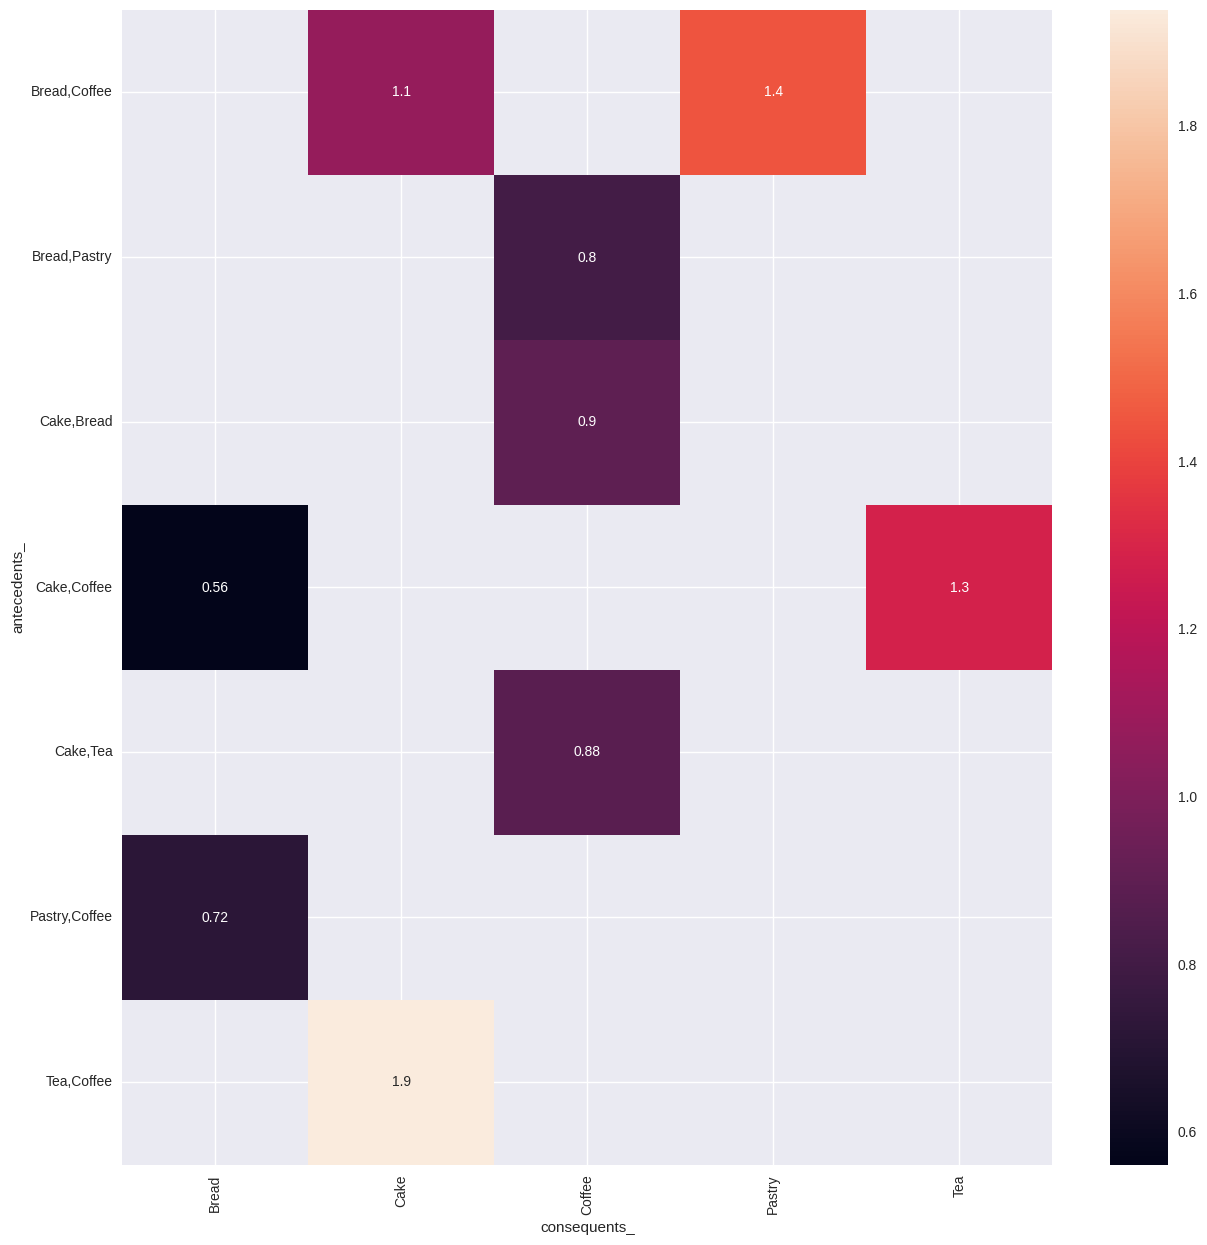

In [12]:
apriori_rules['lhs_items'] = apriori_rules['antecedents'].apply(lambda x:len(x) )
apriori_rules[apriori_rules['lhs_items']>1].sort_values('lift', ascending=False).head()
apriori_rules['antecedents_'] = apriori_rules['antecedents'].apply(lambda a: ','.join(list(a)))
apriori_rules['consequents_'] = apriori_rules['consequents'].apply(lambda a: ','.join(list(a)))
pivot = apriori_rules[apriori_rules['lhs_items']>1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Another great visualization library I absolutely love is the PyARMViz library which can work with complex large scale rules. Let's first generate a parallel categories plot

In [13]:
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict

apriori_vis = apriori_rules

apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = 20507

transactions = [a[1]['Item'].tolist() for a in list(data.groupby(['Transaction', 'date_time']))]
def tran():
    for t in transactions:
        yield t
def antec(x):
    cnt = 0
    for t in tran():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1
    return cnt
vis = apriori_vis.values.tolist()
rules_dict = []
for i in vis:
    i[10] = antec(i[0])
    i[11] = antec(i[1])
    i[9] = antec(i[0].union(i[1]))
    diction = {
        'lhs': tuple(i[0]),
        'rhs': tuple(i[1]),
        'count_full': i[9],
        'count_lhs': i[10],
        'count_rhs': i[11],
        'num_transactions': i[12]
    }
    rules_dict.append(diction)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
rules = []
for rd in rules_dict:
    rules.append(generate_rule_from_dict(rd))

PyARMViz.generate_parallel_category_plot(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ofcourse this plot is much more useful with larger number of association rules. So let's try using the same analysis this time with 0.5% minimum support threshold

In [15]:
f_items = apriori(apriori_basket_set, min_support = 0.005, use_colnames = True)
apriori_rules = association_rules(f_items, metric = 'lift', min_threshold = 0.005)
apriori_rules.sort_values('confidence', ascending = False, inplace = True)

apriori_vis = apriori_rules

apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = 20507

transactions = [a[1]['Item'].tolist() for a in list(data.groupby(['Transaction', 'date_time']))]
def tran():
    for t in transactions:
        yield t
def antec(x):
    cnt = 0
    for t in tran():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1
    return cnt
vis = apriori_vis.values.tolist()
rules_dict = []
for i in vis:
    i[10] = antec(i[0])
    i[11] = antec(i[1])
    i[9] = antec(i[0].union(i[1]))
    diction = {
        'lhs': tuple(i[0]),
        'rhs': tuple(i[1]),
        'count_full': i[9],
        'count_lhs': i[10],
        'count_rhs': i[11],
        'num_transactions': i[12]
    }
    rules_dict.append(diction)
    rules = []
for rd in rules_dict:
    rules.append(generate_rule_from_dict(rd))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



In [16]:
PyARMViz.generate_parallel_category_plot(rules)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Now let's take a look at the network graph plot for the rules.



In [21]:
PyARMViz.generate_rule_strength_plot(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

